### Урок 5. Сегментация изображений
Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g

In [1]:
!pip install segmentation_models_pytorch
!pip install kaggle --upgrade


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import torch
from torch import nn, optim
import segmentation_models_pytorch as smp

from pathlib import Path

In [4]:
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples


  0%|          | 0.00/2.38G [00:00<?, ?B/s]
  0%|          | 1.00M/2.38G [00:00<39:18, 1.08MB/s]
  0%|          | 2.00M/2.38G [00:01<31:09, 1.36MB/s]
  0%|          | 3.00M/2.38G [00:02<28:32, 1.49MB/s]
  0%|          | 4.00M/2.38G [00:02<27:19, 1.55MB/s]
  0%|          | 5.00M/2.38G [00:03<26:40, 1.59MB/s]
  0%|          | 6.00M/2.38G [00:04<26:15, 1.62MB/s]
  0%|          | 7.00M/2.38G [00:04<28:29, 1.49MB/s]
  0%|          | 8.00M/2.38G [00:05<30:18, 1.40MB/s]
  0%|          | 9.00M/2.38G [00:06<31:33, 1.34MB/s]
  0%|          | 10.0M/2.38G [00:07<32:09, 1.32MB/s]
  0%|          | 11.0M/2.38G [00:08<32:51, 1.29MB/s]
  0%|          | 12.0M/2.38G [00:09<33:05, 1.28MB/s]
  1%|          | 13.0M/2.38G [00:10<33:48, 1.25MB/s]
  1%|          | 14.0M/2.38G [00:10<35:05, 1.21MB/s]
  1%|          | 15.0M/2.38G [00:11<34:11, 1.24MB/s]
  1%|          | 16.0M/2.38G [00:12<34:31, 1.22MB/s]
  1%|          | 17.0M/2.38G [00:13<34:24, 1.23MB/s]
  1%|          | 18.0M/2.38G [00:14<34:38, 1.22MB/s]
 

In [13]:
!kaggle datasets list


ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                 DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36           1650        165  1.0              
derrekdevon/real-estate-sales-2001-2020                         Real Estate Sales 2001-2020                       28MB  2023-12-07 15:36:26            861         23  1.0              
muhammadbinimran/housing-price-prediction-data                  Housing Price Prediction Data                    763KB  2023-11-21 17:56:32           7356        132  1.0              
jocelyndumlao/cardiovascular-disease-dataset                    Cardiovascu

In [23]:
DATASET_FILEPATH = Path('set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [25]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [26]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [27]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [34]:
IMG_SIZE = 256

def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask

class LipsDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')
        masks = [cls_mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return img.float(), masks

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [30]:
BACKBONE = 'resnet50'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\AlenWolker/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [01:51<00:00, 920kB/s] 


In [36]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

C:\Users\AlenWolker\AppData\Local\Temp\ipykernel_23472\2493531912.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  masks = torch.as_tensor(masks, dtype=torch.float)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


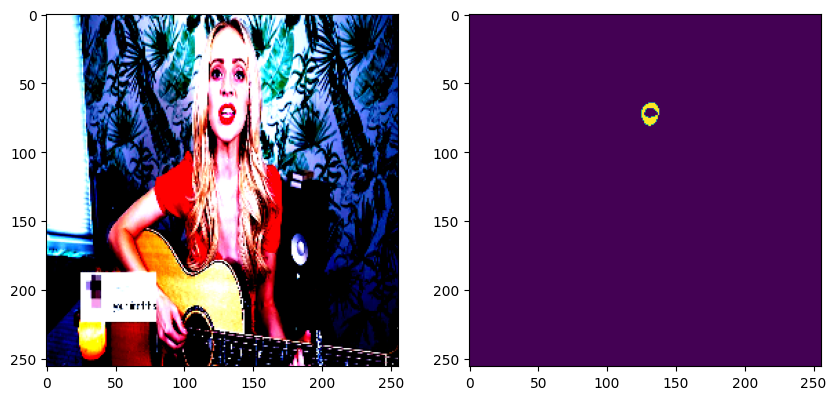

In [37]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [38]:
from segmentation_models_pytorch import utils as smp_utils

criterion = smp_utils.losses.BCELoss()
metrics = [smp_utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [39]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train:  41%|████▏     | 1036/2498 [52:37<1:13:13,  3.01s/it, bce_loss - 0.01556, iou_score - 0.6804]

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

In [ ]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')